## Gaussian Process Regression from scratch (1D)

Autor: Ole Uphaus

In diesem Jupyter Notebook werde ich **Gauß-Prozesse** nutzen, um ein **Regeressionsproblem** zu lösen. Dabei werde ich nicht auf integrierte Pakete zurückgreifen, sondern alle mathematischen Grundlagen selber implementieren.

In [29]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt

### 1. Trainingsdaten erzeugen

In [30]:
def gen_base_points(n, x_min, x_max, seed=42):
    """
    Generate approximately evenly spaced base points using 1D Latin Hypercube Sampling (LHS).

    This method divides the interval [x_min, x_max] into n segments of equal width
    and samples one random point within each segment.

    Parameters
    ----------
    n : int
        Number of points to generate.
    x_min : float
        Lower bound of the interval.
    x_max : float
        Upper bound of the interval.
    seed : int, optional
        Random seed for reproducibility.

    Returns
    -------
    points : (n,) ndarray
        Array of n uniformly distributed points in the interval [x_min, x_max].
    """

    rng = np.random.default_rng(seed=42)
    random_segment_points = (np.arange(n) + rng.random(n)) / n
    x = x_min + (x_max - x_min) * random_segment_points

    return np.sort(x)

def f_true(x):
    """
    True function to generate target values.

    Parameters
    ----------
    x : (n,) ndarray
        Input points.

    Returns
    -------
    y : (n,) ndarray
        Target values corresponding to input points.
    """
    return 0.5 * np.sin(x) + 0.5 * np.cos(0.7*x + 0.5)

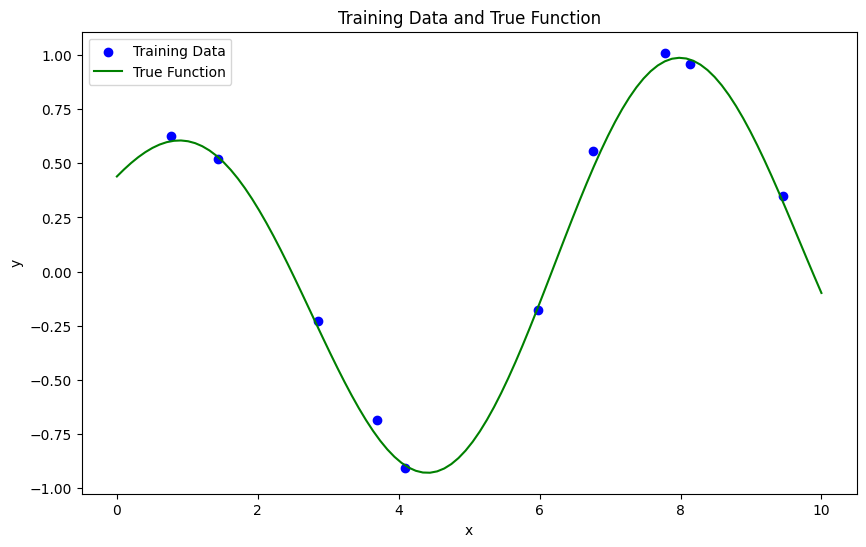

In [35]:
np.random.seed(42)

# Generate training data
n_train = 10
x_min, x_max = 0, 10
sigma = 0.05


X_train = gen_base_points(n_train, x_min, x_max)
Y_train = f_true(X_train) + sigma * np.random.randn(n_train) # Random normal distributed noise

# Plot training data
plt.figure(figsize=(10, 6))
plt.scatter(X_train, Y_train, color='blue', label='Training Data')
plt.plot(np.linspace(x_min, x_max, 100), f_true(np.linspace(x_min, x_max, 100)), color='green', label='True Function')
plt.title('Training Data and True Function')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()